In [1]:
%matplotlib inline


# Compare over-sampling samplers

The following example attends to make a qualitative comparison between the
different over-sampling algorithms available in the imbalanced-learn package.


In [2]:
# Authors: Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: MIT

In [3]:
print(__doc__)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")

Automatically created module for IPython interactive environment


The following function will be used to create toy dataset. It uses the
:func:`~sklearn.datasets.make_classification` from scikit-learn but fixing
some parameters.



In [4]:
from sklearn.datasets import make_classification


def create_dataset(
    n_samples=1000,
    weights=(0.92, 0.08),
    n_classes=2,
    class_sep=0.8,
    n_clusters=1,
):
    return make_classification(
        n_samples=n_samples,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=n_classes,
        n_clusters_per_class=n_clusters,
        weights=list(weights),
        class_sep=class_sep,
        random_state=0,
    )

The following function will be used to plot the sample space after resampling
to illustrate the specificities of an algorithm.



In [5]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

The following function will be used to plot the decision function of a
classifier given some data.



In [6]:
import numpy as np


def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

## Illustration of the influence of the balancing ratio

We will first illustrate the influence of the balancing ratio on some toy
data using a logistic regression classifier which is a linear model.



In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()

We will fit and show the decision boundary model to illustrate the impact of
dealing with imbalanced classes.



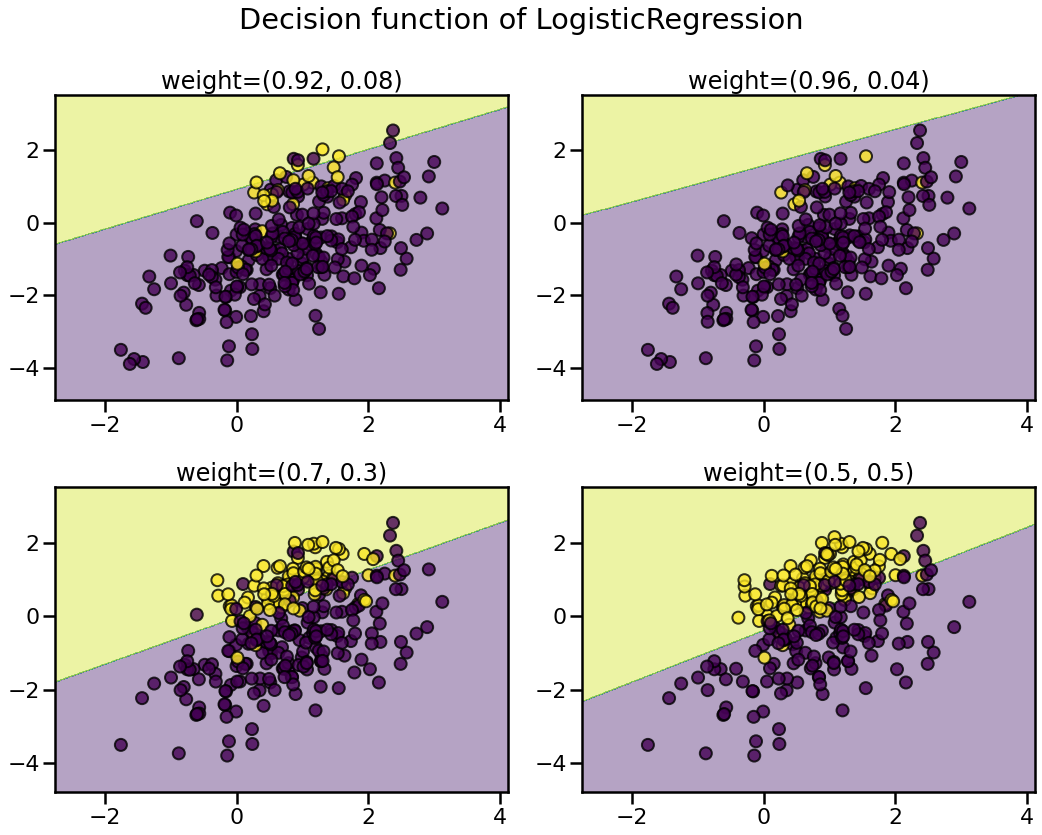

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

weights_arr = (
    (0.92, 0.08),
    (0.96, 0.04),
    (0.7, 0.3),
    (0.5, 0.5),
)
for ax, weights in zip(axs.ravel(), weights_arr):
    X, y = create_dataset(n_samples=300, weights=weights)
    clf.fit(X, y)
    plot_decision_function(X, y, clf, ax, title=f"weight={weights}")
    fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()

Greater is the difference between the number of samples in each class, poorer
are the classification results.

## VAE over-sampling to balance the data set

Random over-sampling can be used to repeat some samples and balance the
number of samples between the dataset. It can be seen that with this trivial
approach the boundary decision is already less biased toward the majority
class. The class :class:`~imblearn.over_sampling.RandomOverSampler`
implements such of a strategy.



In [9]:
from VAEOversampler import VAEOversampler

2023-07-09 02:31:40.396209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-09 02:31:40.396231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


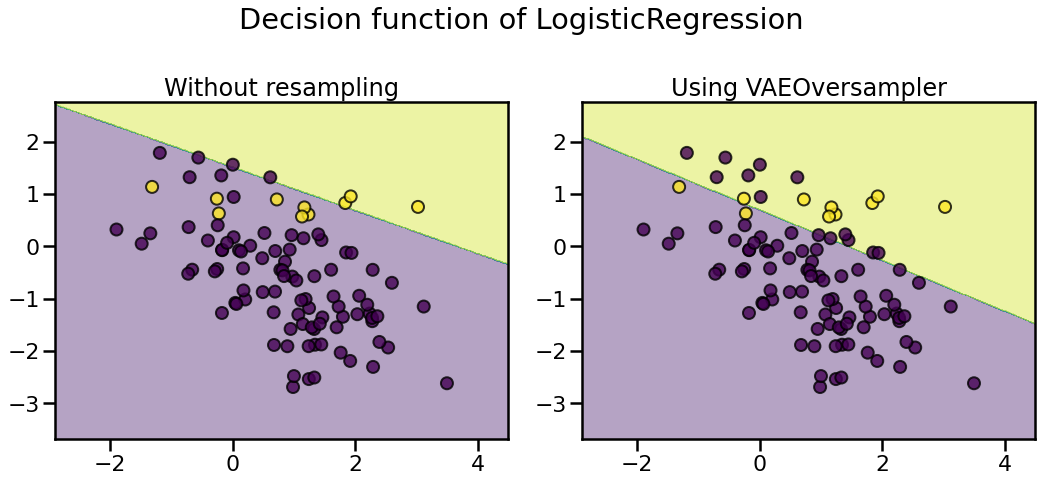

In [16]:
from imblearn.pipeline import make_pipeline

X, y = create_dataset(n_samples=100, weights=(0.9, 0.1))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

clf.fit(X, y)
plot_decision_function(X, y, clf, axs[0], title="Without resampling")

sampler = VAEOversampler(epochs=500, intermediate_dim=512, rescale=True, random_state=0, verbose=False)
model = make_pipeline(sampler, clf).fit(X, y)
plot_decision_function(X, y, model, axs[1], f"Using {model[0].__class__.__name__}")

fig.suptitle(f"Decision function of {clf.__class__.__name__}")
fig.tight_layout()

By default, random over-sampling generates a bootstrap. The parameter
`shrinkage` allows adding a small perturbation to the generated data
to generate a smoothed bootstrap instead. The plot below shows the difference
between the two data generation strategies.



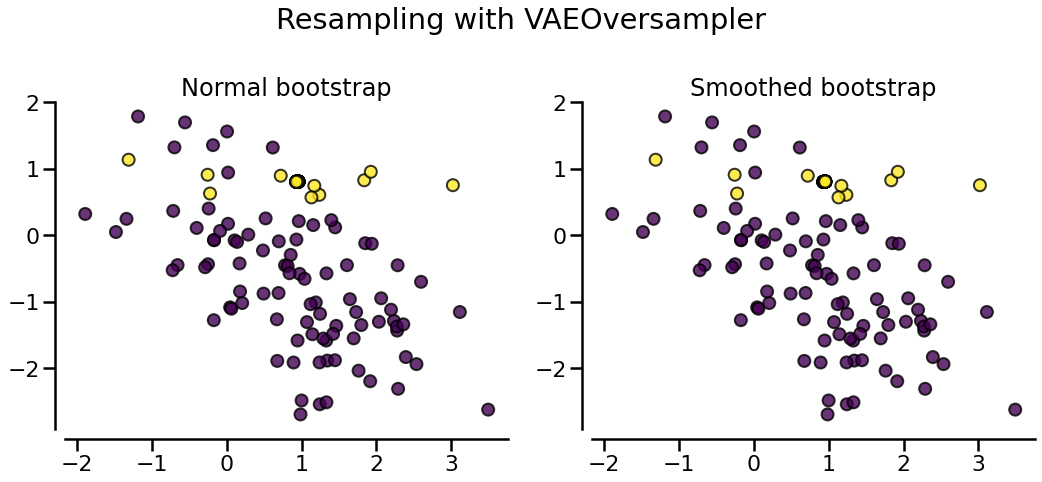

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

#sampler.set_params(shrinkage=None)
plot_resampling(X, y, sampler, ax=axs[0], title="Normal bootstrap")

#sampler.set_params(shrinkage=0.3)
plot_resampling(X, y, sampler, ax=axs[1], title="Smoothed bootstrap")

fig.suptitle(f"Resampling with {sampler.__class__.__name__}")
fig.tight_layout()

It looks like more samples are generated with smoothed bootstrap. This is due
to the fact that the samples generated are not superimposing with the
original samples.

## More advanced over-sampling using ADASYN and SMOTE

Instead of repeating the same samples when over-sampling or perturbating the
generated bootstrap samples, one can use some specific heuristic instead.
:class:`~imblearn.over_sampling.ADASYN` and
:class:`~imblearn.over_sampling.SMOTE` can be used in this case.



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5288791670>
Traceback (most recent call last):
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback a

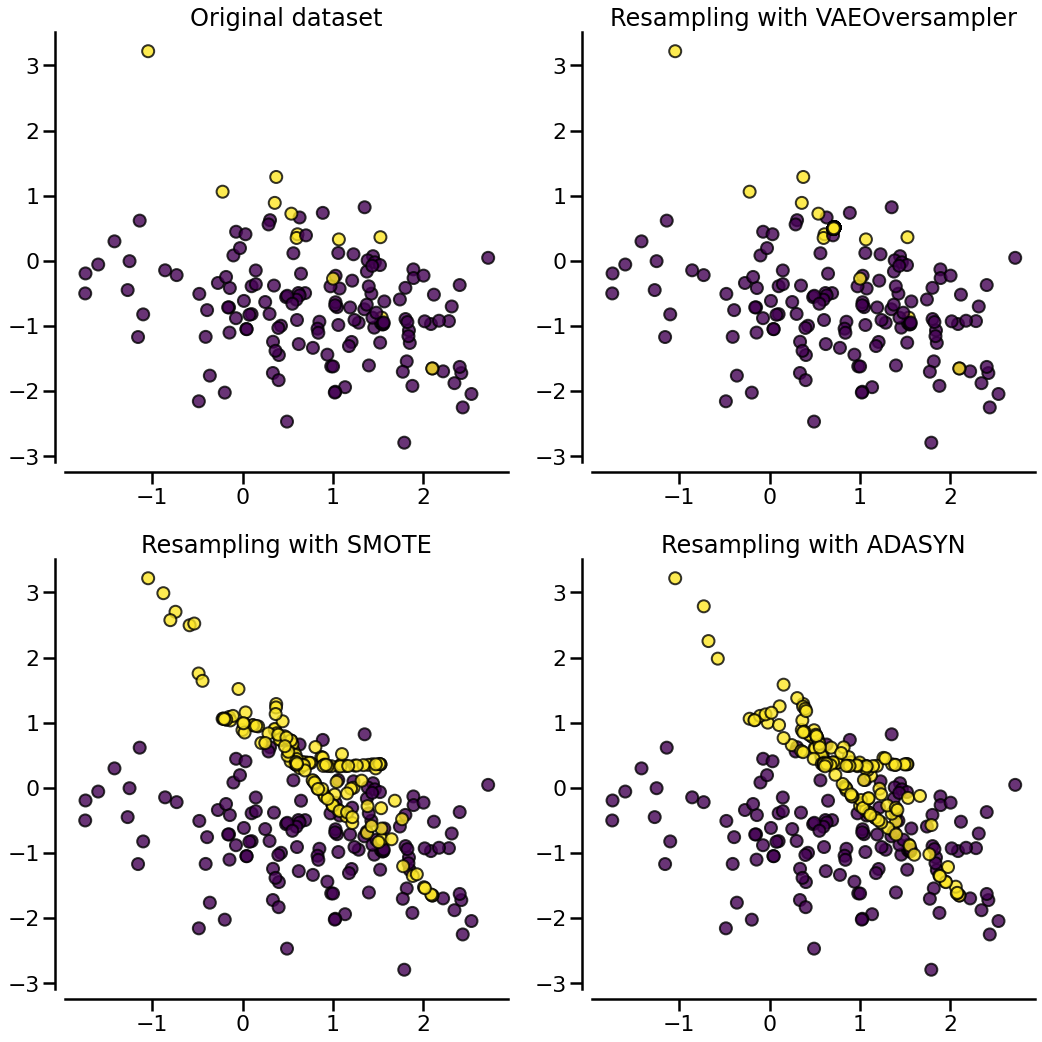

In [18]:
from imblearn import FunctionSampler  # to use a idendity sampler
from imblearn.over_sampling import ADASYN, SMOTE

X, y = create_dataset(n_samples=150, weights=(0.91, 0.09))

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

samplers = [
    FunctionSampler(),
    VAEOversampler(epochs=500, intermediate_dim=512, rescale=True, random_state=0, verbose=False),
    SMOTE(random_state=0),
    ADASYN(random_state=0),
]

for ax, sampler in zip(axs.ravel(), samplers):
    title = "Original dataset" if isinstance(sampler, FunctionSampler) else None
    plot_resampling(X, y, sampler, ax, title=title)
fig.tight_layout()

The following plot illustrates the difference between
:class:`~imblearn.over_sampling.ADASYN` and
:class:`~imblearn.over_sampling.SMOTE`.
:class:`~imblearn.over_sampling.ADASYN` will focus on the samples which are
difficult to classify with a nearest-neighbors rule while regular
:class:`~imblearn.over_sampling.SMOTE` will not make any distinction.
Therefore, the decision function depending of the algorithm.



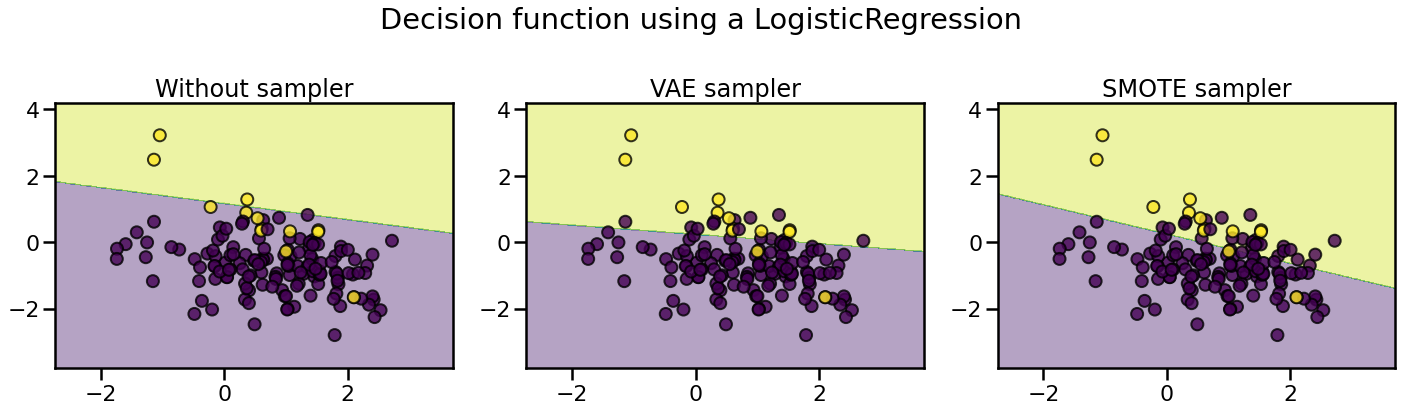

In [19]:
X, y = create_dataset(n_samples=150, weights=(0.9, 0.1))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

models = {
    "Without sampler": clf,
    "VAE sampler": make_pipeline(VAEOversampler(epochs=500, intermediate_dim=512, rescale=True, random_state=0, verbose=False), clf),
    "SMOTE sampler": make_pipeline(SMOTE(random_state=0), clf),
}

for ax, (title, model) in zip(axs, models.items()):
    model.fit(X, y)
    plot_decision_function(X, y, model, ax=ax, title=title)

fig.suptitle(f"Decision function using a {clf.__class__.__name__}")
fig.tight_layout()

Due to those sampling particularities, it can give rise to some specific
issues as illustrated below.



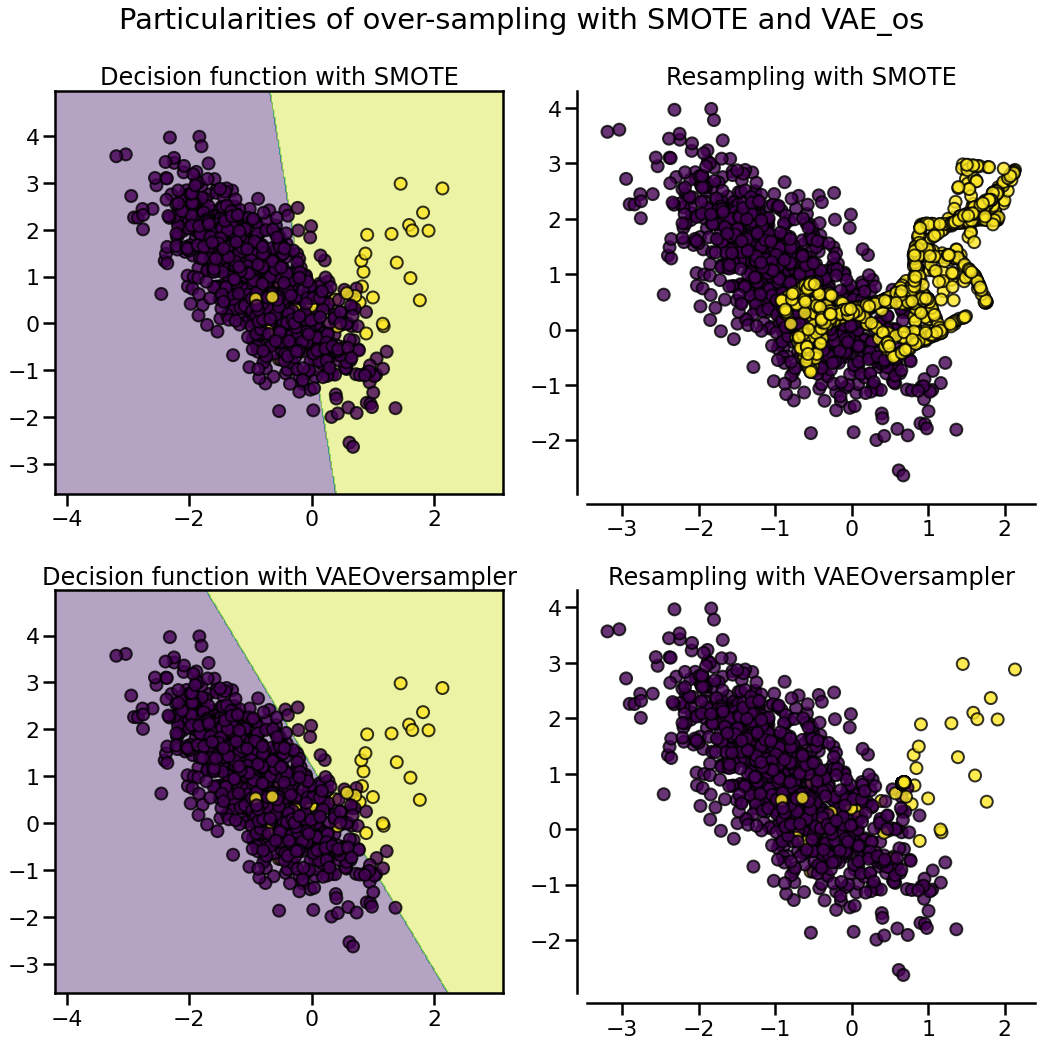

In [20]:
X, y = create_dataset(n_samples=1000, weights=(0.97, 0.03), class_sep=0.8)

samplers = [SMOTE(random_state=0), VAEOversampler(epochs=500, intermediate_dim=512, rescale=True, random_state=0, verbose=False)]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
for ax, sampler in zip(axs, samplers):
    model = make_pipeline(sampler, clf).fit(X, y)
    plot_decision_function(
        X, y, clf, ax[0], title=f"Decision function with {sampler.__class__.__name__}"
    )
    plot_resampling(X, y, sampler, ax[1])

fig.suptitle("Particularities of over-sampling with SMOTE and VAE_os")
fig.tight_layout()

SMOTE proposes several variants by identifying specific samples to consider
during the resampling. The borderline version
(:class:`~imblearn.over_sampling.BorderlineSMOTE`) will detect which point to
select which are in the border between two classes. The SVM version
(:class:`~imblearn.over_sampling.SVMSMOTE`) will use the support vectors
found using an SVM algorithm to create new sample while the KMeans version
(:class:`~imblearn.over_sampling.KMeansSMOTE`) will make a clustering before
to generate samples in each cluster independently depending each cluster
density.



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f52887960d0>
Traceback (most recent call last):
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/a/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback a

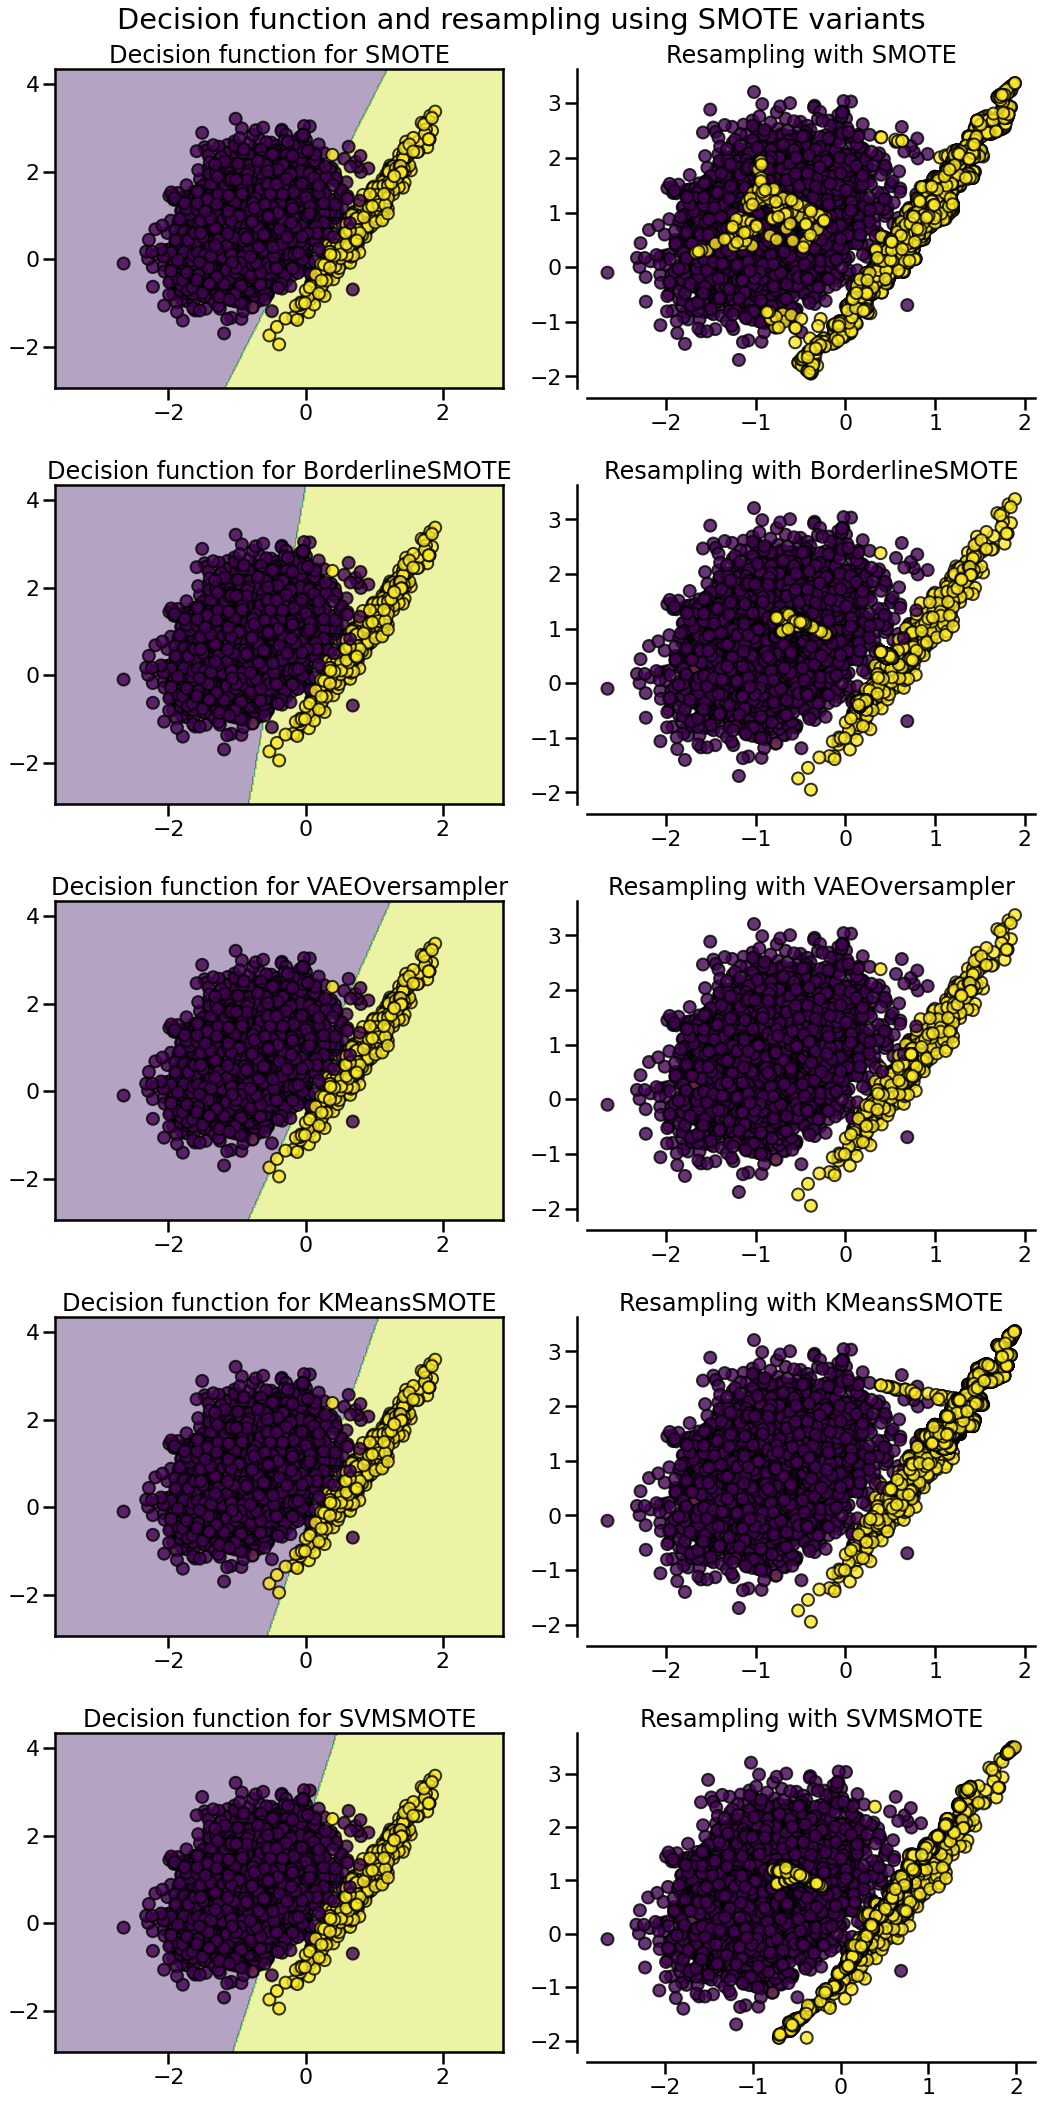

In [21]:
from sklearn.cluster import MiniBatchKMeans

from imblearn.over_sampling import SVMSMOTE, BorderlineSMOTE, KMeansSMOTE

X, y = create_dataset(n_samples=5000, weights=(0.9, 0.1), class_sep=0.8)

fig, axs = plt.subplots(5, 2, figsize=(15, 30))

samplers = [
    SMOTE(random_state=0),
    BorderlineSMOTE(random_state=0, kind="borderline-1"),
    VAEOversampler(epochs=500, intermediate_dim=512, rescale=True, random_state=0, verbose=False),
    KMeansSMOTE(
        kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=0
    ),
    SVMSMOTE(random_state=0),
]

for ax, sampler in zip(axs, samplers):
    model = make_pipeline(sampler, clf).fit(X, y)
    plot_decision_function(
        X, y, clf, ax[0], title=f"Decision function for {sampler.__class__.__name__}"
    )
    plot_resampling(X, y, sampler, ax[1])

fig.suptitle("Decision function and resampling using SMOTE variants")
fig.tight_layout()